# 프로그래밍 언어별 출판 데이터 분석 (데이터 수집)

In [1]:
# requirements
import os
import sys
import urllib.request
import requests
import numpy as np
import pandas as pd
import json
import datetime
import random
import time
import platform
import re

from time import sleep
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup as bs
from fake_useragent import UserAgent

In [2]:
# 한글 설정
from matplotlib import font_manager, rc
%matplotlib inline

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    rc("font", family="Arial Unicode MS")
elif platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc("font", family="font_name")
else:
    print("Unknown System. Sorry")

----
## 1. TIOBE INDEX의 상위 9개 언어와 R언어에 대한 책 정보 수집하기

----
### 1-1. [Naver Books API 사용](https://developers.naver.com/docs/search/book/)
   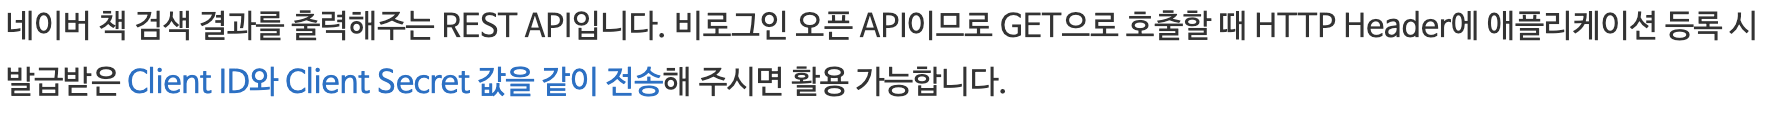

In [21]:
# Naver API 클라이언트 사용 정보 (* client_id 및 client_secret 값 넣어줄 것)

client_id = ""
client_secret = ""

### 1-2. 검색어 목록 구성
+ 관련 검색어를 예측하여 딕셔너리 형태로 정리

In [4]:
# 언어별 검색할 문구

language_dict ={
    "Python": ["Python", "python", "Python 언어", "파이썬 언어", "파이선", "파이썬 프로그래밍"],
    "C" : ["C language", "c language", "C 언어", "C 프로그래밍"],
    "JAVA" : ["JAVA 언어", "JAVA 프로그래밍", "자바 프로그래밍"],
    "C++" : ["c++ 언어", "C++ 프로그래밍", "c++ language", "C++ language","c++ programing"],
    "C#" : ["C#", "C# 언어", "C# 프로그래밍", "c# language", "C# programming"],
    "Visual Basic" : ["Visual Basic", "Visual Basic 프로그래밍", "비쥬얼베이직", "Visual Basic Programming"],
    "JavaScript" : ["JavaScript", "javascript 언어", "javascript language", "JavaScript 프로그래밍", "자바 스크립트"],
    "SQL" : ["SQL언어","SQL 언어", "SQL 프로그래밍", "SQL programming", "SQL language"],
    "PHP" : ["php언어","php 언어", "PHP 프로그래밍", "php language", "php programming"],
    "R" : ["R언어", "R 언어", "R 프로그래밍", "R language", "R programming"]            
}

In [5]:
# 언어 리스트
language = language_dict.keys()
language

dict_keys(['Python', 'C', 'JAVA', 'C++', 'C#', 'Visual Basic', 'JavaScript', 'SQL', 'PHP', 'R'])

### 1-3. gen_search_url()
- 네이버 검색 API 주소 생성

In [6]:
def gen_search_url(api_node, search_text, start_num, disp_num, datefrom):
    base = "https://openapi.naver.com/v1/search"
    node = "/" + api_node + ".json" 
    param_query = "?query=" + urllib.parse.quote(search_text) # 검색할 단어 
    param_start = "&start=" + str(start_num) # 검색할 시작 인덱스
    param_disp = "&display=" + str(disp_num) # 검색할 마지막 인덱스
    param_d_dafr = "&d_dafr" + str(datefrom) # datefrom 이후에 출판된 도서

    return base + node + param_query + param_start + param_disp + param_d_dafr

### 1-4. gen_result_onepage()
- 네이버 검색 API 요청함수

In [7]:
def get_result_onepage(url):
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    response = urllib.request.urlopen(request)
    print("[%s] Url Request Success" % datetime.datetime.now())
    return json.loads(response.read().decode("utf-8"))

In [8]:
# test
url = gen_search_url("book", "Python", 1, 1, 20170101)
test_result = get_result_onepage(url)
test_result

[2021-12-29 21:14:02.352449] Url Request Success


{'lastBuildDate': 'Wed, 29 Dec 2021 21:14:02 +0900',
 'total': 6804,
 'start': 1,
 'display': 1,
 'items': [{'title': '<b>python</b>으로 배우는 OpenCv 프로그래밍',
   'link': 'http://book.naver.com/bookdb/book_detail.php?bid=21368146',
   'image': 'https://bookthumb-phinf.pstatic.net/cover/213/681/21368146.jpg?type=m1&udate=20211218',
   'author': '김동근',
   'price': '28000',
   'discount': '25200',
   'publisher': '가메',
   'pubdate': '20211215',
   'isbn': '8980783108 9788980783106',
   'description': '2018년 출간되었던 “<b>PYTHON</b>으로 배우는 OPENCV 프로그래밍”의 개정판으로 내용을 보완하여 - <b>PYTHON</b> 3.10과 OPENCV 4.5 사용- NUMPY, MATPLOTLIB, PAFY, YOUTUBE_DL, PYGAMES. PYOPENGL - 영상 및 비디오 입출력과 녹화- 임계값, 히스토그램 처리, 영상 필터링, 분할- 특징 검출, 디스크립터... '}]}

In [9]:
# 수집된 data 확인
test_result["items"]

[{'title': '<b>python</b>으로 배우는 OpenCv 프로그래밍',
  'link': 'http://book.naver.com/bookdb/book_detail.php?bid=21368146',
  'image': 'https://bookthumb-phinf.pstatic.net/cover/213/681/21368146.jpg?type=m1&udate=20211218',
  'author': '김동근',
  'price': '28000',
  'discount': '25200',
  'publisher': '가메',
  'pubdate': '20211215',
  'isbn': '8980783108 9788980783106',
  'description': '2018년 출간되었던 “<b>PYTHON</b>으로 배우는 OPENCV 프로그래밍”의 개정판으로 내용을 보완하여 - <b>PYTHON</b> 3.10과 OPENCV 4.5 사용- NUMPY, MATPLOTLIB, PAFY, YOUTUBE_DL, PYGAMES. PYOPENGL - 영상 및 비디오 입출력과 녹화- 임계값, 히스토그램 처리, 영상 필터링, 분할- 특징 검출, 디스크립터... '}]

In [10]:
# 제목 확인
test_result["items"][0]["title"]

'<b>python</b>으로 배우는 OpenCv 프로그래밍'

### 1-5. delete_tags()
- 파싱해서 받아온 문자열에 있는 < b > 태그 삭제

In [11]:
def delete_tag(input_str):
    input_str = input_str.replace("<b>", "")
    input_str = input_str.replace("</b>", "")
    return input_str 

In [12]:
# 각 항목별 <b> 태그 삭제 확인
print("제목:", delete_tag(test_result["items"][0]["title"]))
print("ISBN:", delete_tag(test_result["items"][0]["isbn"]))
print("출판사:", delete_tag(test_result["items"][0]["publisher"]))
print("출판일:", delete_tag(test_result["items"][0]["pubdate"]))
print("가격:", delete_tag(test_result["items"][0]["price"]))

제목: python으로 배우는 OpenCv 프로그래밍
ISBN: 8980783108 9788980783106
출판사: 가메
출판일: 20211215
가격: 28000


### 1-6. get_page_num()
- 페이지 분량에 대한 정보는 책 상세 페이지(link)에서 수집

In [13]:
# 수집된 링크 확인
test_result["items"][0]["link"]

'http://book.naver.com/bookdb/book_detail.php?bid=21368146'

In [14]:
# attempt 1

# def get_page_num(link):
#     response = requests.get(link)
#     soup = BeautifulSoup(response.content, "html.parser")
#     return soup.select_one("#container > div.spot > div.book_info > div.book_info_inner > div:nth-child(3)").text.strip().split("|")[0].split(" ")[1]

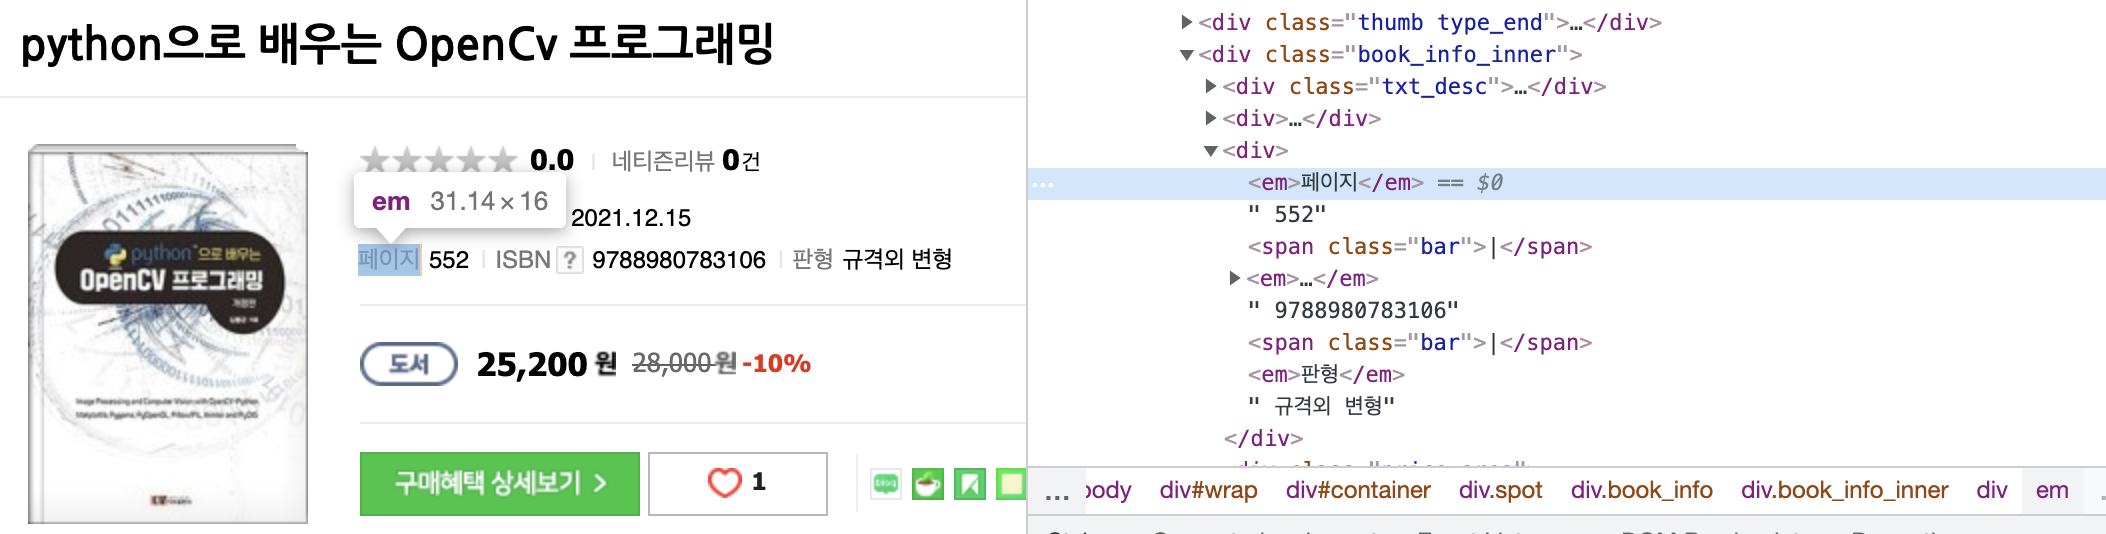

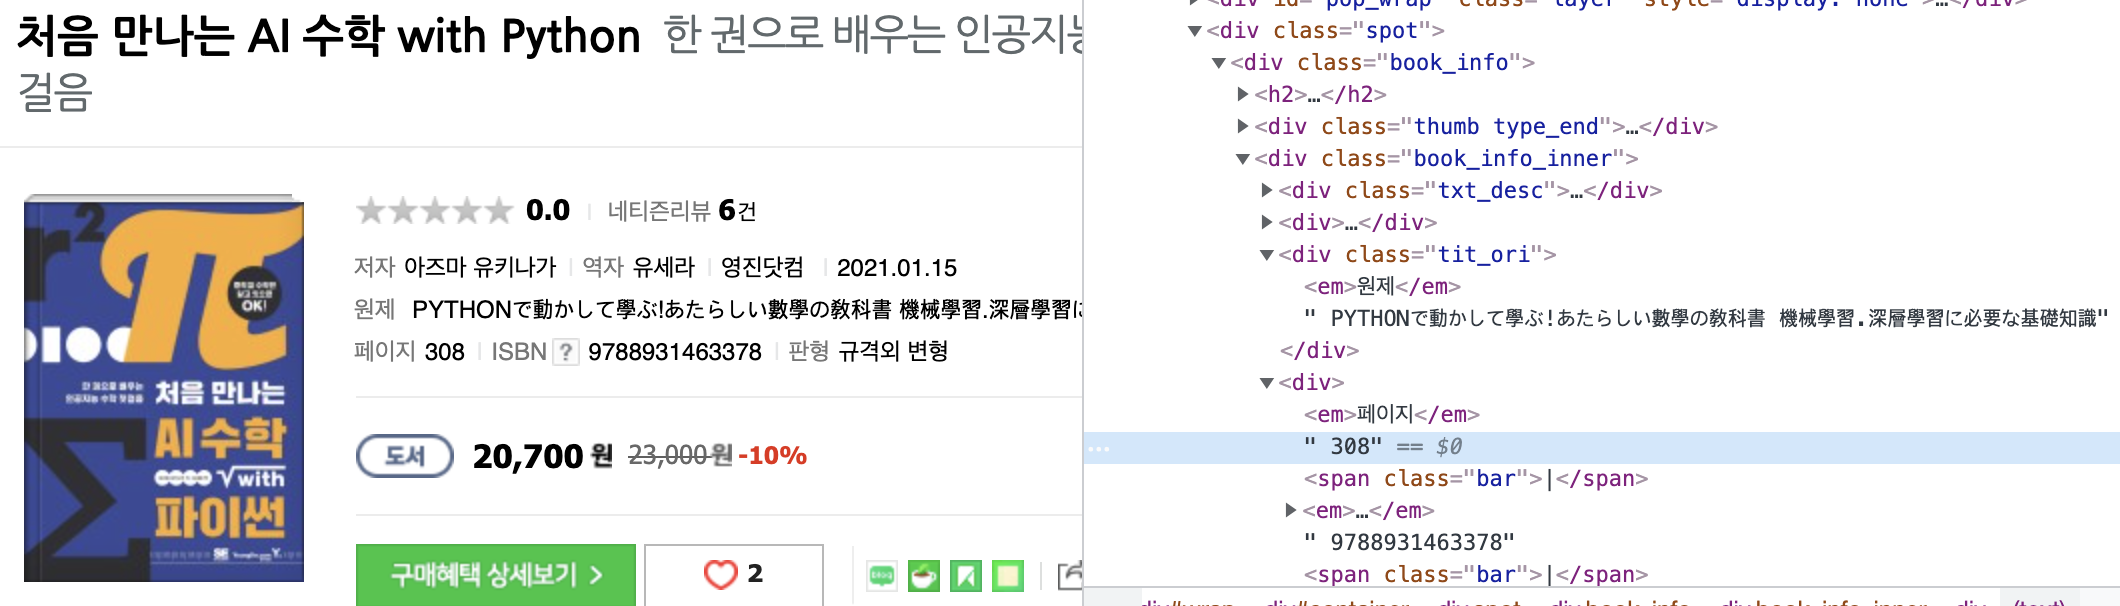

- **문제** : 위의 사진처럼, 동일한 html 태그 위치에서 페이지수 숫자가 아닌 문자가 반환되는 경우 발견

- **분석** :
    - 페이지수에 문자가 반환되었던 책을 따로 검색해 html 태그를 살펴보니 페이지 수가 div:nth-child(3)이 아니라 div:nth-child(4)에 담겨있는 것 확인
    - 이는 번역서의 경우 "원제" 정보를 담은 div 태그가 앞에 끼워져 있기 때문으로 판단
</br>
- **해결**: div:nth-child(3) 확인해서 숫자가 없으면 div:nth-child(4) 조회해보도록 함수 수정함

In [15]:
def get_page_num(link):
    response = requests.get(link)
    soup = bs(response.content, "html.parser")
    try:
        page_num_tmp = re.findall("\d+", soup.select_one("#container > div.spot > div.book_info > div.book_info_inner > div:nth-child(3)").text)
        if page_num_tmp == []:
            page_num_tmp = re.findall("\d+", soup.select_one("#container > div.spot > div.book_info > div.book_info_inner > div:nth-child(4)").text)
    except:
        page_num_tmp = ["0"]
    return page_num_tmp[0]

In [16]:
get_page_num(test_result["items"][0]["link"])

'552'

### 1-7 get_fields()
- 제목, 작가, 가격, 할인가격, 책고유번호, 출판사, 출판날짜, 책링크 파싱, 프로그래밍 언어 카테고리, 페이지 수 파싱


In [17]:
def get_fields(json_data, word):
    title = [delete_tag(each["title"]) for each in json_data["items"]]
    author = [delete_tag(each["author"]) for each in json_data["items"]]
    price = [each["price"] for each in json_data["items"]]
    discount = [each["discount"] for each in json_data["items"]]
    isbn = [each["isbn"] for each in json_data["items"]]
    publisher = [delete_tag(each["publisher"]) for each in json_data["items"]]
    pubdate = [each["pubdate"] for each in json_data["items"]]
    link = [each["link"] for each in json_data["items"]]
    page = [get_page_num(each["link"]) for each in json_data["items"]]
    print("page: ", page)
    result_pd = pd.DataFrame({
        "책제목": title,
        "작가": author,
        "가격": price,
        "할인가격": discount,
        "ISBN": isbn,
        "출판사": publisher,
        "출판일": pubdate,
        "link" : link,
        "언어": word,
        "페이지수": page,
    }, columns=["책제목", "작가", "가격", "할인가격", "ISBN", "출판사", "출판일", "link", "언어", "페이지수"])
    return result_pd

### 1-8 TIOBE 기준 상위 9개 프로그래밍 언어와 R언어에 대한 데이터 수집

In [18]:
# #전체 Naver API 관련 함수 결합하여 도서 정보 수집 (**데이터 수집시, 주석 해제하여 사용할 것)

# # 전체 언어별 검색 합칠 리스트 선언
# language_file = []

# # language리스트에 선언된 것을 기준으로 하여 아래의 for문에서 dictionary 키에 적용
# for word in language:
#     tmp = []
#     for detail_word in language_dict[word]:
#         for n in range(1, 1000, 100):
#             url = gen_search_url("book", detail_word, n, 100, 20170101)
#             json_result = get_result_onepage(url)
#             pd_result=get_fields(json_result, word)
#             tmp.append(pd_result)
#         language_file = pd.concat(tmp)
        
#         #타임 설정안하면 429 Bad Request-> 크롤링 문제 발생
#         time.sleep(random.randint(3, 6))
#         print(detail_word)
    
#     #파일 저장
#     writer = pd.ExcelWriter("./data/" + word + "_raw.xlsx", engine="xlsxwriter")
#     language_file.to_excel(writer, sheet_name = word)
#     writer.save()

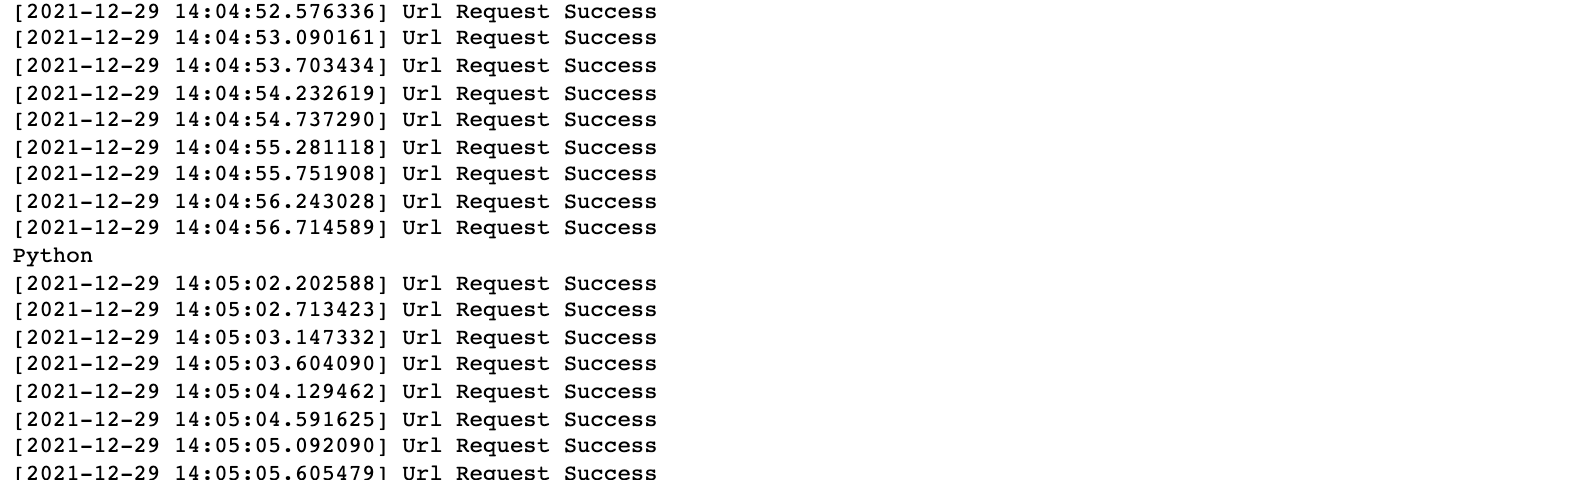

----
### 1-9 데이터 확인

In [19]:
# 각 파일 불러오기
data_python = pd.read_excel("../data/Python_raw.xlsx")
data_c = pd.read_excel("../data/C_raw.xlsx")
data_java = pd.read_excel("../data/JAVA_raw.xlsx")
data_cpp = pd.read_excel("../data/C++_raw.xlsx")
data_csharp = pd.read_excel("../data/C#_raw.xlsx")
data_vb = pd.read_excel("../data/Visual Basic_raw.xlsx")
data_js = pd.read_excel("../data/JavaScript_raw.xlsx")
data_sql = pd.read_excel("../data/SQL_raw.xlsx")
data_php = pd.read_excel("../data/PHP_raw.xlsx")
data_r = pd.read_excel("../data/R_raw.xlsx")

data_raw = [data_python, data_c, data_java, data_cpp, data_csharp, data_vb, data_js, data_sql, data_php, data_r]

In [20]:
for rawfile in data_raw:
    rawfile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4411 non-null   int64  
 1   책제목         4411 non-null   object 
 2   작가          4400 non-null   object 
 3   가격          4411 non-null   int64  
 4   할인가격        3479 non-null   float64
 5   ISBN        4411 non-null   object 
 6   출판사         4411 non-null   object 
 7   출판일         4411 non-null   int64  
 8   link        4411 non-null   object 
 9   언어          4411 non-null   object 
 10  페이지수        4411 non-null   int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 379.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4000 non-null   int64  
 1   책제목         4000 non-null   object 
 2   작가          3991 non

In [23]:
# data_python 확인
data_python.head(5)

,Unnamed: 0,책제목,작가,가격,할인가격,ISBN,출판사,출판일,link,언어,페이지수
0,0,python으로 배우는 OpenCv 프로그래밍,김동근,28000,25200.0,8980783108 9788980783106,가메,20211215,http://book.naver.com/bookdb/book_detail.php?b...,Python,552
1,1,처음 만나는 AI 수학 with Python (한 권으로 배우는 인공지능 수학 첫걸음),아즈마 유키나가,23000,20700.0,8931463375 9788931463378,영진닷컴,20210115,http://book.naver.com/bookdb/book_detail.php?b...,Python,308
2,2,프로그래머를 위한 Python,폴 데이텔|하비 데이텔,38000,34200.0,8931556829 9788931556827,성안당,20211223,http://book.naver.com/bookdb/book_detail.php?b...,Python,776
3,3,Applied Numerical Methods with Python for Engi...,Clough|David,374140,NaN,1266651497 9781266651496,McGraw-HillEducation,20211207,http://book.naver.com/bookdb/book_detail.php?b...,Python,9781266651496
4,4,"Programming Basics: Getting Started with Java,...",Ciesla|Robert,66360,NaN,1484272854 9781484272855,Apress,20211220,http://book.naver.com/bookdb/book_detail.php?b...,Python,9781484272855
